In [1]:
import matplotlib.pyplot as plt, numpy as np, noise
from skimage import io
from skimage.morphology import (disk, ball)
from skimage.filters import roberts

In [2]:
# Set Radius of island and island seed, plus misc options
seed = 14
r = 100
pond_cutoff = 10
rook_adjacency = False
truncation = False

In [3]:
# Initializing some things for later
d = (r*2)+1
ponds = []
pond_pixels = []

In [4]:
# Define Pixel class for each tile of heightmap
class Pixel:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.vol = 0.1
        self.pointer = self
    
    # Convenience method for printing
    def coordinates(self):
        return (self.x, self.y, self.z)
    
    # Method which returns list of pixels adjacent to a pixel, including the pixel itself
    def get_adjacents(self):
        adjacents = []
        if rook_adjacency == False:
            for i in range(3):
                for j in range(3):
                    adjacents.append(pancake[self.y-1+i][self.x-1+j])
        else:
            adjacents.append(pancake[self.y-1][self.x])
            adjacents.append(pancake[self.y+1][self.x])
            adjacents.append(pancake[self.y][self.x-1])
            adjacents.append(pancake[self.y][self.x+1])
            adjacents.append(self)
        return adjacents
    
    # Method which determines which pixel the pixel will outflow to
    def update_pointer(self):
        to_beat = 999999999
        lowest = self
        for adj in self.get_adjacents():
            if adj.z < to_beat:
                to_beat = adj.z
                lowest = adj
        self.pointer = lowest

In [5]:
# Pond Class definition
class Pond:
    def __init__(self, origin):
        self.members = [origin]
        self.z = origin.z
        self.pointer = origin
        self.vol = 0
        self.edges = [origin]
        self.update_edges()
    
    # Method which determines which pixels are adjacent to the pond, but not members of it
    def update_edges(self):
        adjs = self.pointer.get_adjacents()
        for adj in adjs:
            if (adj not in self.edges) and (adj not in self.members) and (adj in eclair):
                self.edges.append(adj)
        self.edges.remove(self.pointer)
    
    # Method which determines which pixel the pond will outflow to
    def update_pond_pointer(self):
        to_beat = 999999999
        lowest = self.members[0]
        for edge in self.edges:
            if edge.z <= to_beat:
                to_beat = edge.z
                lowest = edge
        self.pointer = lowest
    
    # Method which raises a pond's level until it finds and outflow point (i.e. an adjacent pixel lower than the pond level)
    def rise(self):
        last_pond = self
        while True:
            self.update_pond_pointer()
            if self.pointer.z >= self.z:
                
                # Pond collision loop
                for pond in ponds:
                    if pond == self:
                        continue
                    if (self.pointer in pond.members):
                        pond.members += self.members
                        for edge in self.edges:
                            if (edge not in pond.edges) and (edge not in pond.members):
                                pond.edges.append(edge)
                        to_remove = []
                        for edge in pond.edges:
                            if (edge in self.members):
                                to_remove.append(edge)
                        for edge in to_remove:
                            pond.edges.remove(edge)
                        ponds.remove(self)
                        last_pond = pond.rise()
                        break
                
                # Rise update if pond doesn't collide
                if self in ponds:
                    self.update_edges()
                    self.z = self.pointer.z
#                     for member in self.members:
#                         member.z = self.z
                    self.members.append(self.pointer)
                    if self.pointer in self.edges:
                        self.edges.remove(self.pointer)
                else:
                    break
            else:
                break
        return last_pond
        
    # Method to determine the volume - NOT level - of a pond. Volume represents the total flowthrough, not pond depth
    def vol_update(self):
        self.vol = 0.1*len(self.members)
        inflows = self.edges
        for inflow in inflows:
            if (inflow.pointer in self.members) and (inflow not in pond_pixels):
                self.vol += inflow.vol

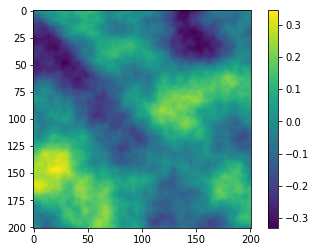

In [6]:
# This cell adapted from https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401 to generate perlin using Noise module
shape = (d,d)
scale = r
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(d):
    for j in range(d):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=seed)
        
plt.imshow(world)
plt.colorbar();

In [7]:
# Generate ball, flatten to 2d array
bosco = ball(r)
biscotti = np.sum(bosco, axis=1)/(d-1)

In [8]:
# Truncation, optional
if truncation == True:
    for i in range(d):
        for j in range(d):
            if biscotti[i][j] > 0.6:
                biscotti[i][j] = 0.6

In [9]:
# Combine world and dome to create textured dome - code to display result commented out
biscuit_land = world+biscotti
# plt.imshow(biscuit_land)
# plt.colorbar();

In [10]:
# test_biscuit = io.imread('./TestBiscuit3.png')
# plt.imshow(test_biscuit);

In [11]:
# d = len(test_biscuit)
# shape = (d,d)
# test_bun = np.zeros(shape)
# for i in range(d):
#     for j in range(d):
#         test_bun[i][j] = test_biscuit[i][j][0]

In [12]:
# test_bun

In [13]:
# test_bun[2][4] = 96

In [14]:
# test_bun[4][6] = 129

In [15]:
# plt.imshow(test_bun)
# plt.colorbar();

In [16]:
# biscuit_land = test_bun

In [17]:
# Set inundation level based on median altitude and put elevations in terms of sea level
flood = np.median(biscuit_land)
for i in range(d):
    for j in range(d):
        biscuit_land[i][j] -= flood

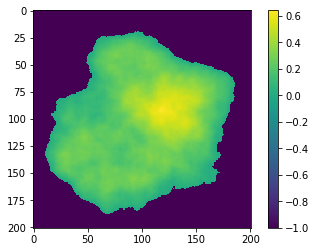

In [18]:
# Inundation visualization - purely graphical
dunked_biscuit = np.zeros((d,d))
for i in range(d):
    for j in range(d):
        if biscuit_land[i][j] < 0:
            dunked_biscuit[i][j] = -1
        else:
            dunked_biscuit[i][j] = biscuit_land[i][j]

plt.imshow(dunked_biscuit)
plt.colorbar();

In [19]:
# Roberts edge detection to determine slopes, this will be used later, commented out for now
# croissant = roberts(biscuit_land)
            
# plt.imshow(croissant)
# plt.colorbar();

In [20]:
# Create array of pixel objects from heightmap
pancake = np.empty(biscuit_land.shape, Pixel)
for i in range(d):
    for j in range(d):
        pancake[i][j] = (Pixel(j, i, biscuit_land[i][j]))

In [21]:
# Create list of pixels from array, excluding array border pixels
eclair = []
for i in range(1,(d-1)):
    for j in range(1,(d-1)):
        eclair.append(pancake[i][j])

In [22]:
# Sort list of pixels by elevation
eclair.sort(key=lambda a : a.z, reverse=True)

In [23]:
# Initial Flow - update pointers and add volume of each pixel to its pointer
for pixel in eclair:
    pixel.update_pointer()
    if pixel.pointer != pixel:
        pixel.pointer.vol += pixel.vol

In [24]:
# Initial Pond Creation
for pixel in reversed(eclair):
    if (pixel.pointer == pixel) and (pixel.vol >= pond_cutoff) and (pixel.z >= 0):
        new_pond = Pond(pixel)
        ponds.append(new_pond)
        new_pond.rise()
        new_pond.vol_update()

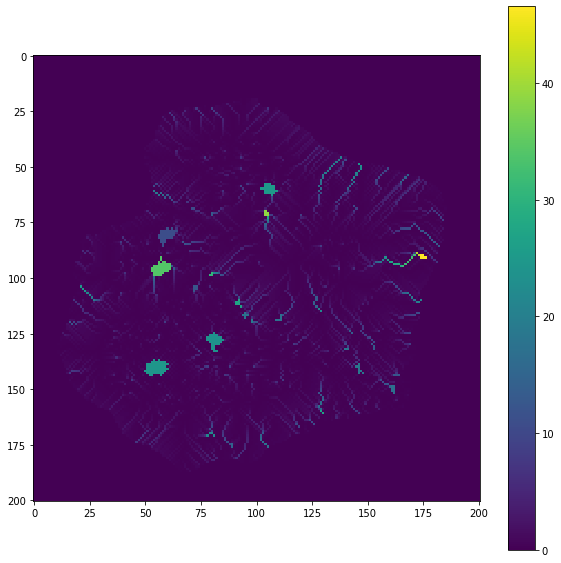

In [25]:
# Full Visualization
plt.figure(figsize=(10,10))
muffin = np.zeros((d,d))
for i in range(d):
    for j in range(d):
        if pancake[i][j].vol > 1000:
            muffin[i][j] = 1000
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = pond.vol
for i in range(d):
    for j in range(d):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
stale_muffin = muffin

plt.imshow(muffin)
plt.colorbar();
stale_muffin = muffin

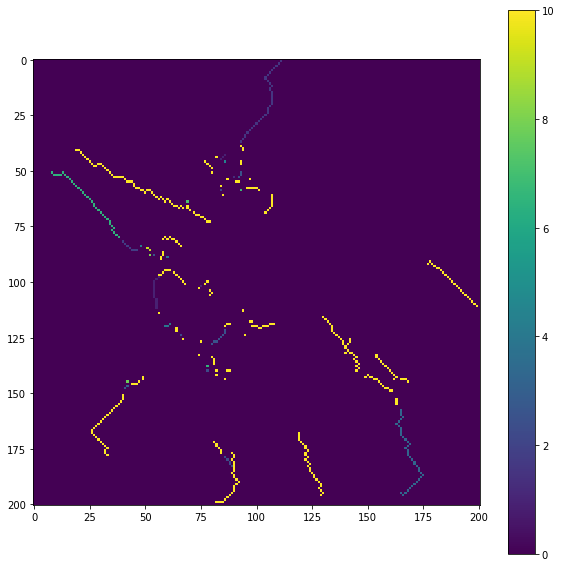

In [26]:
crepe = np.zeros(shape)
for pond in ponds:
    step = pond.pointer
    step2 = step.pointer
    crepe[step.y][step.x] += pond.vol
    while (step != step2) and (step2 in eclair):
        crepe[step2.y][step2.x] += crepe[step.y][step.x]
        step = step2
        step2 = step.pointer
    for member in pond.members:
        if member not in pond_pixels:
            pond_pixels.append(member)
        
for rang in range(100):
    for pixel in reversed(eclair):
        if (pixel.pointer == pixel) and (crepe[pixel.y][pixel.x] != 0) and (pixel not in pond_pixels) and (pixel.z >= 0):
            new_pond = Pond(pixel)
            ponds.append(new_pond)
            new_pond = new_pond.rise()
            new_pond.vol_update()
            step = new_pond.pointer
            step2 = step.pointer
            crepe[step.y][step.x] += new_pond.vol
            while (step != step2) and (step2 in eclair):
                crepe[step2.y][step2.x] += crepe[step.y][step.x]
                step = step2
                step2 = step.pointer
            
            for member in new_pond.members:
                if member not in pond_pixels:
                    pond_pixels.append(member)
            
for i in range(d):
    for j in range(d):
        if crepe[i][j] > 10:
            crepe[i][j] = 10
        
plt.figure(figsize=(10,10))        
plt.imshow(crepe)
plt.colorbar();

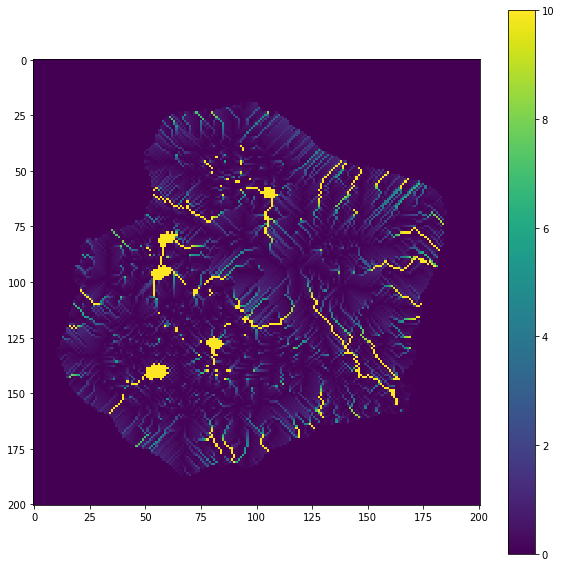

In [27]:
cruffin = crepe+muffin
for i in range(d):
    for j in range(d):
        if pancake[i][j].z <= 0:
            cruffin[i][j] = 0
        if cruffin[i][j] > 10:
            cruffin[i][j] = 10

plt.figure(figsize=(10,10))
plt.imshow(cruffin)
plt.colorbar();

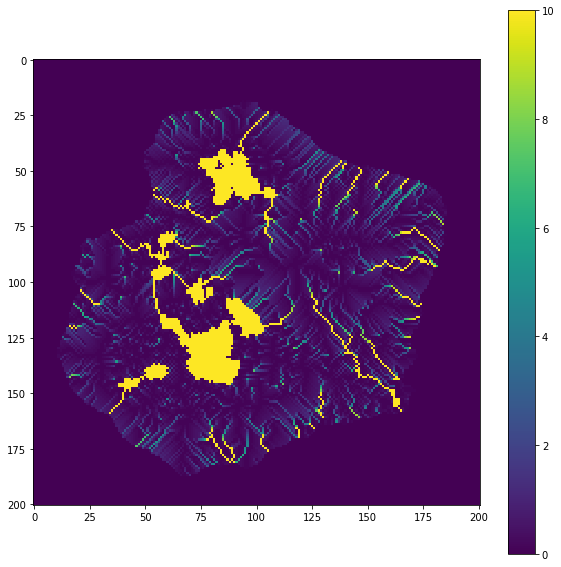

In [28]:
# Re-Flow with pond volumes
bun = np.zeros(shape)

# Rainfall - volume reset and flow
for pixel in eclair:
    pixel.vol = 0.1
    pixel.update_pointer()
for pixel in eclair:
    if pixel.pointer != pixel:
        pixel.pointer.vol += pixel.vol

# Initial vol set for all ponds
for pond in ponds:
    pond.vol_update()

# Ponds cascade from top to bottom BY LEVEL and store cascade in blank array    
for pond in sorted(ponds, key=lambda a : a.z, reverse=True):
    for pond_edge in pond.edges:
        if (pond_edge.pointer in pond.members) and (pond_edge not in pond_pixels):
            pond.vol += bun[pond_edge.y][pond_edge.x]
    step = pond.pointer
    step2 = step.pointer
    if step in pond_pixels:
        for pondy in ponds:
            if step in pondy.members:
                pondy.vol += pond.vol
                break
        continue
    bun[step.y][step.x] += pond.vol
    while (step != step2) and (step2 in eclair):
        bun[step2.y][step2.x] += bun[step.y][step.x]
        step = step2
        step2 = step.pointer
        
# Rainfall vols added to cascade array
for pixel in eclair: 
    bun[pixel.y][pixel.x] += pixel.vol
    
# Set pond pixel vols to pond vol in cascade array
for pond in ponds:
    for member in pond.members:
        bun[member.y][member.x] = pond.vol
        
# Set ocean pixels to constant and cap vols if desired
for i in range(d):
    for j in range(d):
        if pancake[i][j].z <= 0:
            bun[i][j] = 0
        if bun[i][j] > 10:
            bun[i][j] = 10
            
plt.figure(figsize=(10,10))
plt.imshow(bun)
plt.colorbar();

In [29]:
# Ready-to-use visualization cell for bugfixes
# crumpet = np.zeros(shape)
# for pixel in eclair:
#     crumpet[pixel.y][pixel.x] = pixel.vol
# plt.figure(figsize=(15,15))
# plt.imshow(crumpet)
# plt.colorbar();

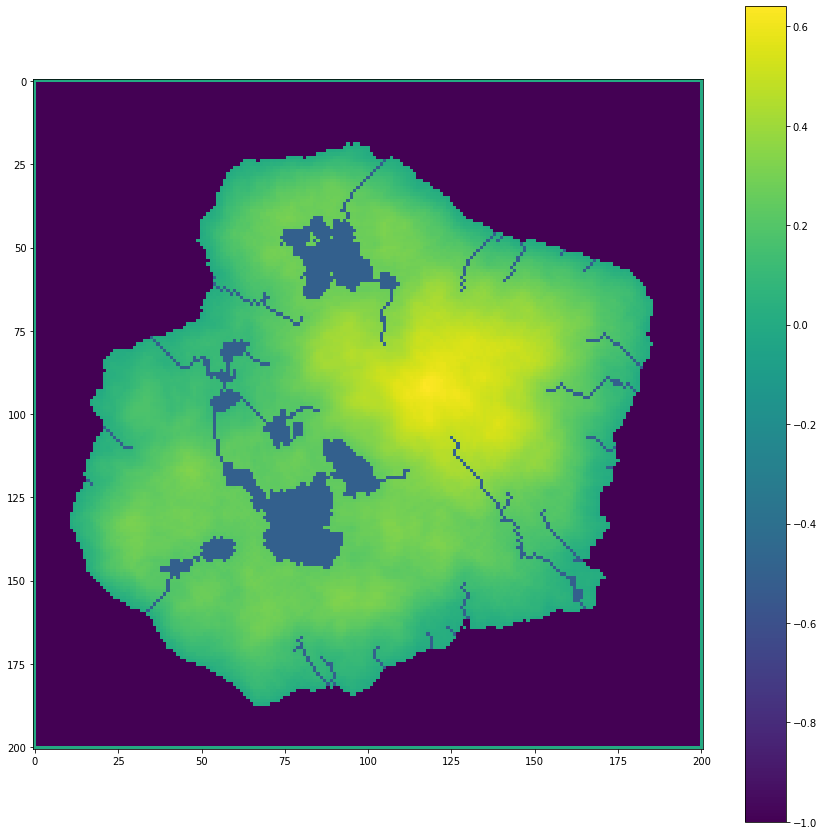

In [30]:
# Visualization, but pretty!
crumpet = np.zeros(shape)
for pixel in eclair:
    if bun[pixel.y][pixel.x] == 10:
        crumpet[pixel.y][pixel.x] = -0.5
    elif bun[pixel.y][pixel.x] == 0:
        crumpet[pixel.y][pixel.x] = -1
    else:
        crumpet[pixel.y][pixel.x] = pixel.z
plt.figure(figsize=(15,15))
plt.imshow(crumpet)
plt.colorbar();